In [1]:
import os
import random
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import transforms as T
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from tensorboardX import SummaryWriter
from sklearn.model_selection import train_test_split
from augmentor import Augmentor
from image_loader import ImageLoader, PatchGenerator

/mmfs1/data/linok/.conda/envs/merons/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 140
print("img_size={}".format(img_size))

transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
])

train_imgloader = ImageLoader('./dataset/images', './dataset/augmented_masks', Augmentor(), img_size)
train_imgloader, val_imgloader = train_imgloader.split([train_imgloader.images[0]])
train_patches = np.array(list(PatchGenerator(train_imgloader)))
val_patches = np.array(list(PatchGenerator(val_imgloader)))

img_size=140


In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks):
        self.imgs = imgs
        self.masks = masks

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        im = self.imgs[index]
        mask = self.masks[index]
        
        im = im.reshape([1, im.shape[0], im.shape[1]])
        mask = mask.reshape([1, mask.shape[0], mask.shape[1]])
                                    
        return tuple([im, mask])

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

In [5]:
train_ds = Dataset(train_patches[:, 0], train_patches[:, 1])
val_ds = Dataset(train_patches[:, 0], train_patches[:, 1])

train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=10)
val_loader = torch.utils.data.DataLoader(val_ds, shuffle=False, batch_size=10)

epochs = 2000
lr = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = UNet(n_channels=1, n_classes=1).to(device)
lossFunc = nn.MSELoss()
opt = torch.optim.SGD(unet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100, eta_min=0)

writer = SummaryWriter('./post_csrnet/runs/size={}, no_transforms'.format(img_size))

In [6]:
for epoch in tqdm(range(epochs)):
    unet.train()
    total_train_loss = 0
    total_val_loss = 0

    for x, y in train_loader:
        x = x.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.float)
        
        pred = unet(x)
        loss = lossFunc(pred, y)
        total_train_loss += loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()

    with torch.no_grad():
        unet.eval()

        for x, y in val_loader:
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)
            
            pred = unet(x)                                
            loss = lossFunc(pred, y)
            total_val_loss += loss


    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    writer.add_scalar('train_loss', avg_train_loss, epoch)
    writer.add_scalar('val_loss', avg_val_loss, epoch)
    
    if (epoch + 1) % 100 == 0:
        model_param_path = './post_csrnet/model_saves/model_psize={:03}, no_transform, {:04}.pth'.format(img_size, epoch + 1)
        torch.save(unet.state_dict(), model_param_path)

writer.flush()
writer.close()

 30%|████████████████████████████████████▎                                                                                   | 605/2000 [11:17<26:02,  1.12s/it]


KeyboardInterrupt: 

In [7]:
val_loader = torch.utils.data.DataLoader(val_ds, shuffle=False, batch_size=1)

for x, y in val_loader:
    x = x.to(device, dtype=torch.float)
    y = y.to(device, dtype=torch.float)

    pred = unet(x)
    
    x = x.detach().cpu().numpy().squeeze()
    y = y.detach().cpu().numpy().squeeze()
    pred = pred.detach().cpu().numpy().squeeze()
    break

In [ ]:
list(PatchGenerator(val_imgloader))

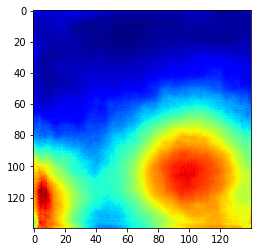

In [9]:
from matplotlib import pyplot as plt
plt.imshow(pred, cmap='jet')